In [1]:
import os
import pickle
import igraph
import geoplot
import seaborn as sns
from collections import Counter
import numpy as np
import itertools
import pandas as pd
import geopandas as gpd
import mapclassify as mc
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import contextily as ctx
from scipy import stats
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
import matplotlib.colors as colors
import matplotlib.ticker as mtick
from collections import defaultdict
import cartopy
import sys
from mpl_toolkits.basemap import Basemap

from statsmodels.nonparametric.kernel_density import *

import GeoDataProcessing.dispatchAnalysis as DA

In [125]:
def loadVehicleRelocations(vehicleRecord, nodes_shp):
    outputDict = {'dashed': [], 'line': [], 'emergency': [], 'marker':[], 'specialMarker':[]}
    for i in range(2, len(vehicleRecord) - 1):
        if vehicleRecord[i][2] is None:
            outputDict['marker'].append((vehicleRecord[i][0], vehicleRecord[i][1]))
        else:
            if vehicleRecord[i+1][1] == vehicleRecord[i][2]:
                if vehicleRecord[i][3] == 'None':
                    i_coords = nodes_shp[nodes_shp['osmid'] == vehicleRecord[i][1]][['lon', 'lat']].values[0]
                    j_coords = nodes_shp[nodes_shp['osmid'] == vehicleRecord[i][2]][['lon', 'lat']].values[0]
                    outputDict['line'].append((vehicleRecord[i][0], i_coords, j_coords))
                else:
                    i_coords = nodes_shp[nodes_shp['osmid'] == vehicleRecord[i][1]][['lon', 'lat']].values[0]
                    j_coords = nodes_shp[nodes_shp['osmid'] == vehicleRecord[i][2]][['lon', 'lat']].values[0]
                    outputDict['emergency'].append((vehicleRecord[i][0], i_coords, j_coords))
            else:
                i_coords = nodes_shp[nodes_shp['osmid'] == vehicleRecord[i][1]][['lon', 'lat']].values[0]
                j_coords = nodes_shp[nodes_shp['osmid'] == vehicleRecord[i][2]][['lon', 'lat']].values[0]
                outputDict['dashed'].append((vehicleRecord[i][0], i_coords, j_coords))

                i_coords = nodes_shp[nodes_shp['osmid'] == vehicleRecord[i][1]][['lon', 'lat']].values[0]
                j_coords = nodes_shp[nodes_shp['osmid'] == vehicleRecord[i+1][1]][['lon', 'lat']].values[0]
                outputDict['line'].append((vehicleRecord[i][0], i_coords, j_coords))

    i_coords = nodes_shp[nodes_shp['osmid'] == vehicleRecord[1][2]][['lon', 'lat']].values[0]
    outputDict['specialMarker'].append((vehicleRecord[1][0], i_coords))
    
    i_coords = nodes_shp[nodes_shp['osmid'] == vehicleRecord[-1][1]][['lon', 'lat']].values[0]
    outputDict['specialMarker'].append((vehicleRecord[-1][0], i_coords))
    return outputDict

def buildRelocationMap(elements):
    fig, axs = plt.subplots(1,1, figsize=(15,15))
    base = Basemap(llcrnrlon=-74.2555913631521349,llcrnrlat=40.4961153951892072,urcrnrlon=-73.7000090632127183,urcrnrlat=40.9155327760000773, epsg=4326, ax=axs)
    
    DATA_DIR = 'C:/Users/Yamil/Proyectos/Proyectos en Git/Memoria Ambulancias/'
    base.readshapefile(DATA_DIR + 'Old Files/Generated Shapefiles/NYC Subdivisions/Borough Boundaries/Borough Boundaries', 'borough')

    for e in elements['dashed']:
        #print(np.array(e[1:])[:, 0], np.array(e[1:])[:, 1])
        base.plot(np.array(e[1:])[:, 0], np.array(e[1:])[:, 1], marker='D', color='black', linestyle='--')
    for e in elements['line']:
        base.plot(np.array(e[1:])[:, 0], np.array(e[1:])[:, 1], marker='D', color='black', linestyle='-')
    for e in elements['emergency']:
        base.plot(np.array(e[1:])[:, 0], np.array(e[1:])[:, 1], marker='D', color='blue', linestyle='-')
    for e in elements['specialMarker']:
        base.plot(e[1][0], e[1][1], marker='D', color='lightgreen', linestyle='-')


In [167]:
def visualize(statistic, show_mean = True, figsize=None):
        if figsize is not None:
            fig, ax = plt.subplots(1,1, figsize=figsize)

        x = []
        y = []
        for i in range(len(statistic.data) - 1):
            if statistic.data[i][0] != statistic.data[i+1][0]:
                x.append(statistic.data[i][0])
                x.append(statistic.data[i+1][0])
                y.append(statistic.data[i][1])
                y.append(statistic.data[i][1])
        plt.plot(x, y, '-')
        
        if show_mean:
            plt.plot([0, statistic.data[-1][0]], [statistic.average()]*2, 'r-')
        
        plt.title('StateStatistic ' + statistic.name + ' over time')
        plt.show()

In [4]:
DATA_DIR = ''
nodes_with_borough = gpd.read_file(DATA_DIR + 'NYC Graph//NYC_nodes_w_borough//NYC_nodes_w_borough.shp')
DATA_DIR = 'C:/Users/Yamil/Proyectos/Proyectos en Git/Memoria Ambulancias/'
nyc_boundaries = gpd.read_file(DATA_DIR + 'Old Files/Generated Shapefiles/NYC Subdivisions/Borough Boundaries/Borough Boundaries.shp')

## Model config name

In [75]:
name = 'D:/FTP results/Possible final 2/friday_{}_0_0.7_0.05_HRDemand_355ALS802BLS_86400_0_8_864000_60_1_1e-06_2160_1200_800_3600.pickle'

### Expected survivors

In [76]:
def SurvivalFunction(response_times):
        return (1 + np.exp(0.679 + .262 * response_times)) ** -1
with open(name.format('SBRDAStatic'), 'rb') as f:
    statistics = pickle.load(f)
print('SBRDAStatic', [sum(SurvivalFunction((e[4] - e[3])/60) if statistics[1][e[-1]]['Statistics']['Borough'].data == b and e[2] == 1 else 0 for e in statistics[2]) for b in range(1,6)])
with open(name.format('SBRDA'), 'rb') as f:
    statistics = pickle.load(f)
print('SBRDA      ', [sum(SurvivalFunction((e[4] - e[3])/60) if statistics[1][e[-1]]['Statistics']['Borough'].data == b and e[2] == 1 else 0 for e in statistics[2]) for b in range(1,6)])
with open(name.format('ROA'), 'rb') as f:
    statistics = pickle.load(f)
print('ROA        ', [sum(SurvivalFunction((e[4] - e[3])/60) if statistics[1][e[-1]]['Statistics']['Borough'].data == b and e[2] == 1 else 0 for e in statistics[2]) for b in range(1,6)])

SBRDAStatic [48.487792710181246, 51.438575037399886, 54.19005918653741, 30.468234226897266, 5.068220627038127]
SBRDA       [53.15372471722386, 56.4002146728531, 62.26772044103796, 35.707517242656635, 6.526055523278387]
ROA         [50.24682497628132, 58.38779929437203, 63.76386702530076, 36.355713914293624, 7.077796876332486]


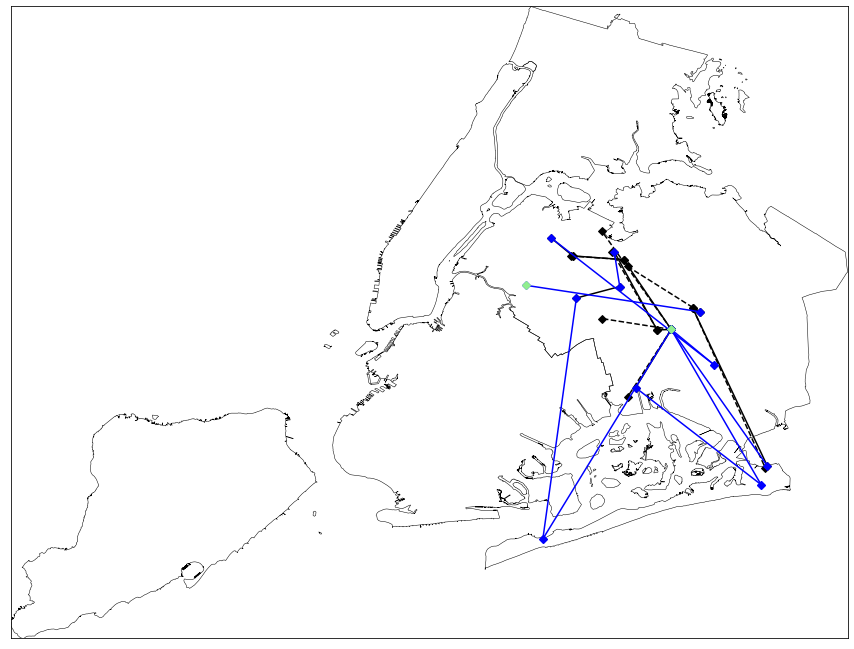

In [204]:
fixed_model = 'SBRDA'
ambulance = 'Ambulance 191'
with open(name.format(fixed_model), 'rb') as f:
    statistics = pickle.load(f)
buildRelocationMap(loadVehicleRelocations(statistics[1][ambulance]['Record'], nodes_with_borough))

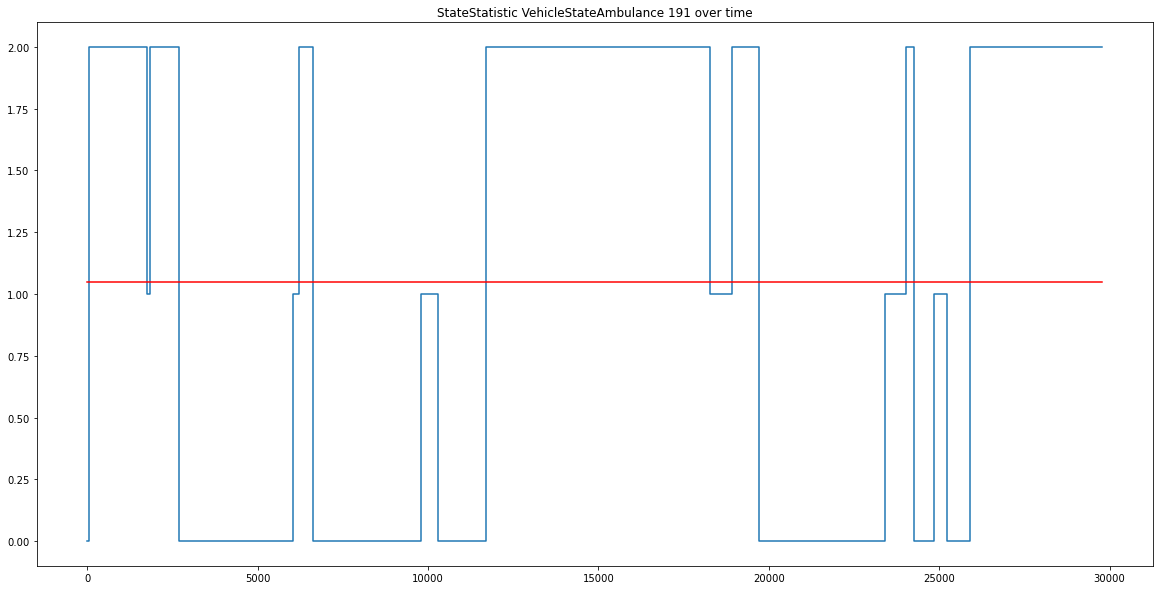

[(0, '42498783', '42498783', 'None', None),
 (0, '1387832646', '1387832646', 'None', None),
 (63.0, '1387832646', '42834208', 'Emergency 5', None),
 (1739.0670867048627, '42834208', '42799695', 'None', None),
 (1836.0, '42842012', '5423651759', 'Emergency 58', None),
 (4029.0058748116985, '261459799', '42857898', 'Emergency 58', '42857898'),
 (6045.982652971284, '42857898', '42903957', 'None', None),
 (6202.0, '42822430', '42858080', 'Emergency 132', None),
 (8707.381775288815, '42788016', '42884462', 'Emergency 132', '42884462'),
 (9801.028780067574, '42884462', '42819225', 'None', None),
 (11711.0, '42819225', '42849278', 'Emergency 220', None),
 (15322.550393028898, '42849278', '42857898', 'Emergency 220', '42857898'),
 (18272.59944884812, '42857898', '42851004', 'None', None),
 (18920.0, '42886437', '42813808', 'Emergency 317', None),
 (21176.974949393203, '42813808', '42857898', 'Emergency 317', '42857898'),
 (23418.835144030894, '42857898', '5951559118', 'None', None),
 (24015.0,

In [207]:
with open(name.format(fixed_model), 'rb') as f:
    statistics = pickle.load(f)
visualize(statistics[1][ambulance]['Statistics']['State'], figsize=(20,10))
statistics[1][ambulance]['Record']

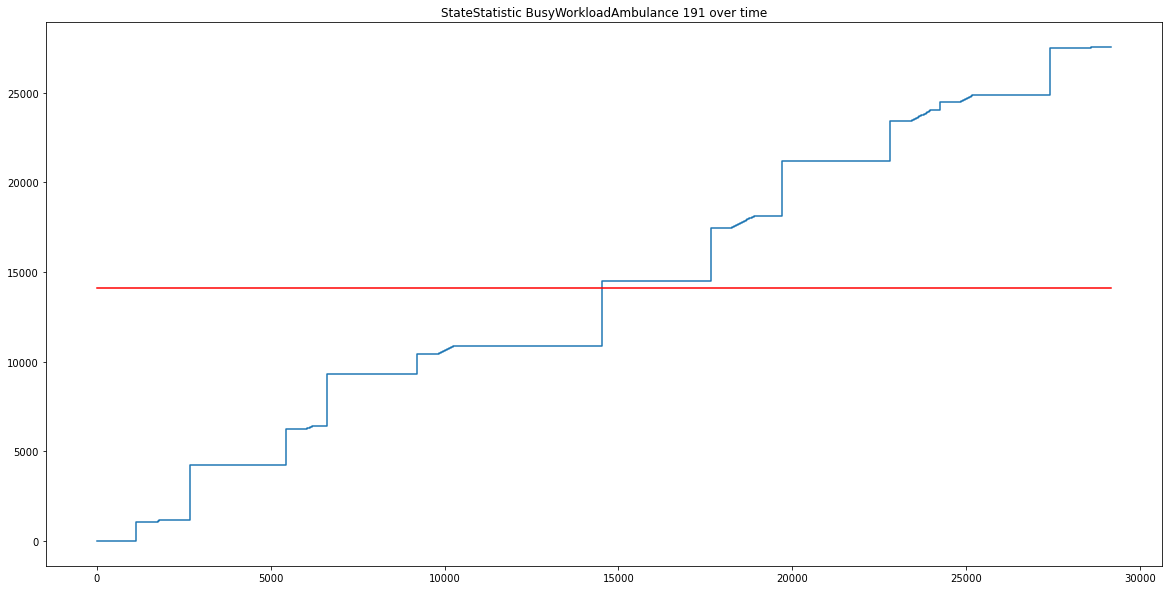

[(0, 0),
 (63.0, 2),
 (1739.0670867048627, 0),
 (1739.0670867048627, 1),
 (1752.3023556414078, 1),
 (1773.1530513842313, 1),
 (1786.0982556082488, 1),
 (1789.2130299390776, 1),
 (1812.745765999668, 1),
 (1823.6990162367103, 1),
 (1830.3321958458805, 1),
 (1833.9259691488444, 1),
 (1836.0, 2),
 (2697.3431587577156, 0),
 (6045.982652971284, 0),
 (6045.982652971284, 1),
 (6057.519581648913, 1),
 (6099.381009120719, 1),
 (6109.624321345933, 1),
 (6117.346462030563, 1),
 (6119.751237290011, 1),
 (6126.165534490098, 1),
 (6132.175451390623, 1),
 (6136.330455636527, 1),
 (6141.421217978272, 1),
 (6151.383038076681, 1),
 (6158.808540964463, 1),
 (6171.364471816944, 1),
 (6183.716857232577, 1),
 (6192.876479155516, 1),
 (6195.042185106892, 1),
 (6202.0, 2),
 (6615.706656104464, 0),
 (9801.028780067574, 0),
 (9801.028780067574, 1),
 (9822.666240259063, 1),
 (9835.18281830409, 1),
 (9854.780196861167, 1),
 (9867.426428676321, 1),
 (9899.270307091409, 1),
 (9903.305643294401, 1),
 (9914.0592134333

In [209]:
visualize(statistics[1][ambulance]['Statistics']['BusyWorkload'], figsize=(20,10))
statistics[1][ambulance]['Record']
statistics[1][ambulance]['Statistics']['State'].data

In [163]:
(1739-63+6045-1836+9801-6202+18272-11711+)/(8*3600)

0.5571180555555556

### Utiization per borough

In [112]:
model = ['SBRDA', 'SBRDAStatic', 'ROA']
utilization = []
for m in model:
    with open(name.format(m), 'rb') as f:
        statistics = pickle.load(f)
    for v in statistics[1].keys():
        ambulance_time = statistics[1][v]['Statistics']['TimeInSystem'].data        
        borough = statistics[1][v]['Statistics']['Borough'].data
        Type = statistics[1][v]['Statistics']['Type'].data
        Shift = statistics[1][v]['Statistics']['Shift'].data
        MetersDriven = statistics[1][v]['Statistics']['MetersDriven'].data[-1][1]

        vehicle_state_1_time = 0
        vehicle_state_2_time = 0
        for i, d in enumerate(statistics[1][v]['Statistics']['State'].data[:-1]):
            if d[1] == 1:
                vehicle_state_1_time += statistics[1][v]['Statistics']['State'].data[i+1][0] - d[0]
            elif d[1] == 2:
                vehicle_state_2_time += statistics[1][v]['Statistics']['State'].data[i+1][0] - d[0]
    

        relocations = 0
        for i, r in enumerate(statistics[1][v]['Record'][1:]):
            if r[1] is not None and r[2] is not None and r[3] == 'None' and statistics[1][v]['Record'][i][3] == 'None':
                relocations += 1
        
        #print(v, ambulance_time, vehicle_state_1_time, vehicle_state_2_time)
        server_utilization = [m, Shift, borough, Type, v, relocations, statistics[1][v]['Statistics']['BusyWorkload'].data[-1][1]/ambulance_time, (ambulance_time - vehicle_state_1_time - vehicle_state_2_time)/ambulance_time, vehicle_state_1_time/ambulance_time, vehicle_state_2_time/ambulance_time, MetersDriven]
        utilization.append(server_utilization)
utilization_df = pd.DataFrame(utilization, columns = ['Model', 'Shift', 'Borough', 'Type', 'id', 'Relocations', 'Busy', 'Idle', 'Reloc', 'Att', 'MetersDriven']).sort_values(['Model','Idle'])        

In [172]:
with open('test12.pickle', 'rb') as f:
    statistics = pickle.load(f)
for v in statistics[1].keys():
    ambulance_time = statistics[1][v]['Statistics']['TimeInSystem'].data        
    borough = statistics[1][v]['Statistics']['Borough'].data
    Type = statistics[1][v]['Statistics']['Type'].data
    Shift = statistics[1][v]['Statistics']['Shift'].data
    MetersDriven = statistics[1][v]['Statistics']['MetersDriven'].data[-1][1]

    vehicle_state_1_time = 0
    vehicle_state_2_time = 0
    for i, d in enumerate(statistics[1][v]['Statistics']['State'].data[:-1]):
        if d[1] == 1:
            vehicle_state_1_time += statistics[1][v]['Statistics']['State'].data[i+1][0] - d[0]
        elif d[1] == 2:
            vehicle_state_2_time += statistics[1][v]['Statistics']['State'].data[i+1][0] - d[0]


    relocations = 0
    for i, r in enumerate(statistics[1][v]['Record'][1:]):
        if r[1] is not None and r[2] is not None and r[3] == 'None' and statistics[1][v]['Record'][i][3] == 'None':
            relocations += 1
    
    #print(v, ambulance_time, vehicle_state_1_time, vehicle_state_2_time)
    server_utilization = ['Model Test', Shift, borough, Type, v, relocations, statistics[1][v]['Statistics']['BusyWorkload'].data[-1][1]/ambulance_time, (ambulance_time - vehicle_state_1_time - vehicle_state_2_time)/ambulance_time, vehicle_state_1_time/ambulance_time, vehicle_state_2_time/ambulance_time, MetersDriven]
    utilization.append(server_utilization)

In [173]:
utilization_df = pd.DataFrame(utilization, columns = ['Model', 'Shift', 'Borough', 'Type', 'id', 'Relocations', 'Busy', 'Idle', 'Reloc', 'Att', 'MetersDriven']).sort_values(['Model','Idle'])      

#### Plot

Text(0.5, 0.98, 'Idle fraction')

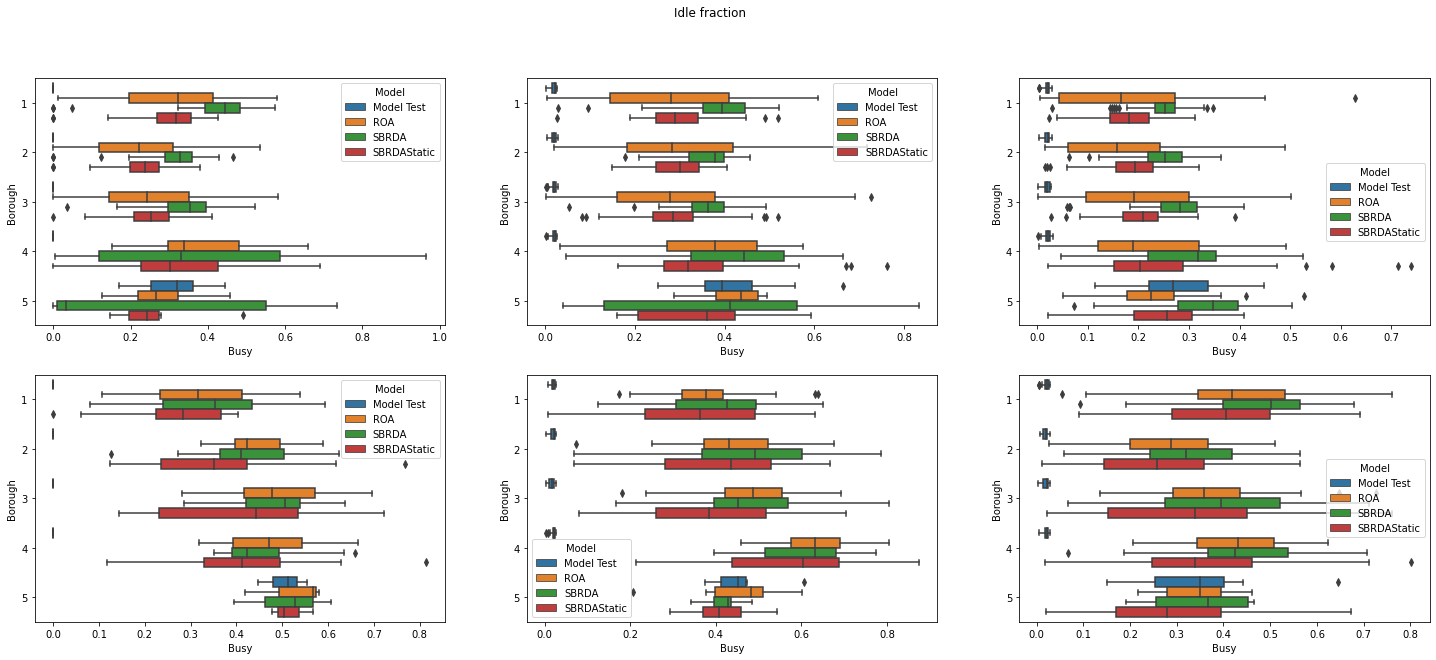

In [175]:
fig, axs = plt.subplots(2,3, figsize=(25,10))
sns.boxplot(data=utilization_df[(utilization_df['Type'] == 1) & (utilization_df['Shift'] == 1)], y='Borough', hue='Model', x='Busy', orient='h', ax = axs[0,0])
sns.boxplot(data=utilization_df[(utilization_df['Type'] == 1) & (utilization_df['Shift'] == 2)], y='Borough', hue='Model', x='Busy', orient='h', ax = axs[0,1])
sns.boxplot(data=utilization_df[(utilization_df['Type'] == 1) & (utilization_df['Shift'] == 3)], y='Borough', hue='Model', x='Busy', orient='h', ax = axs[0,2])
sns.boxplot(data=utilization_df[(utilization_df['Type'] == 0) & (utilization_df['Shift'] == 1)], y='Borough', hue='Model', x='Busy', orient='h', ax = axs[1,0])
sns.boxplot(data=utilization_df[(utilization_df['Type'] == 0) & (utilization_df['Shift'] == 2)], y='Borough', hue='Model', x='Busy', orient='h', ax = axs[1,1])
sns.boxplot(data=utilization_df[(utilization_df['Type'] == 0) & (utilization_df['Shift'] == 3)], y='Borough', hue='Model', x='Busy', orient='h', ax = axs[1,2])

fig.suptitle('Idle fraction')
#plt.legend(handles=[a, b], loc="upper left")

Text(0.5, 0.98, 'Meters Driven')

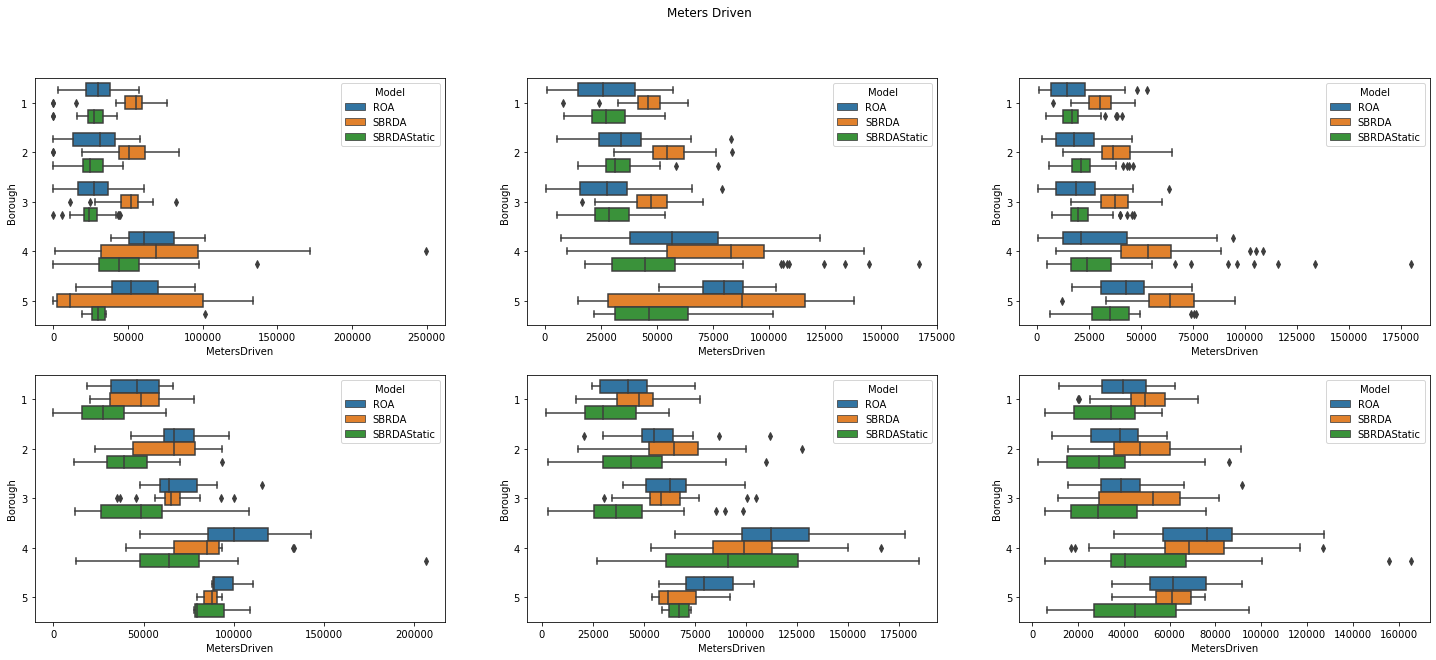

In [113]:
fig, axs = plt.subplots(2,3, figsize=(25,10))
sns.boxplot(data=utilization_df[(utilization_df['Type'] == 1) & (utilization_df['Shift'] == 1)], y='Borough', hue='Model', x='MetersDriven', orient='h', ax = axs[0,0])
sns.boxplot(data=utilization_df[(utilization_df['Type'] == 1) & (utilization_df['Shift'] == 2)], y='Borough', hue='Model', x='MetersDriven', orient='h', ax = axs[0,1])
sns.boxplot(data=utilization_df[(utilization_df['Type'] == 1) & (utilization_df['Shift'] == 3)], y='Borough', hue='Model', x='MetersDriven', orient='h', ax = axs[0,2])
sns.boxplot(data=utilization_df[(utilization_df['Type'] == 0) & (utilization_df['Shift'] == 1)], y='Borough', hue='Model', x='MetersDriven', orient='h', ax = axs[1,0])
sns.boxplot(data=utilization_df[(utilization_df['Type'] == 0) & (utilization_df['Shift'] == 2)], y='Borough', hue='Model', x='MetersDriven', orient='h', ax = axs[1,1])
sns.boxplot(data=utilization_df[(utilization_df['Type'] == 0) & (utilization_df['Shift'] == 3)], y='Borough', hue='Model', x='MetersDriven', orient='h', ax = axs[1,2])

fig.suptitle('Meters Driven')

In [138]:
# Number of relocations
# utilization_df.sort_values(['id', 'Model']).groupby(['Model']).sum()['Relocations']
A = utilization_df.sort_values(['Model', 'Idle', 'id'])
A.to_excel('testtt.xlsx')